# VAE + MLP pipeline for TTR/THS data
### Katherine Duncker
#### 8/16/2024
#### You Lab

This code runs the data pre-processing, data fitting and simulations, VAE-MLP training and results.

## Import necessary packages and define device for torch

In [2]:
#import python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import glob
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#import data loading and pre-processing functions from separate .py files
from data_loading_v5 import define_metadata, import_exp_data, filter_dataframes, process_dataframes, convert_reader_data, subtract,normalize 
from plot_timecourses import plottimecourselist, plottimecoursearray, figure_layout 
from crosstalk import crosstalk, mixed_crosstalk, antibiotic_crosstalk
from dose_response_fitting import dose_response_fitting
from mechanistic_model import difeq_newest_test_2, fp_total_timecourse, sensor_fit, plot_fittings
from VAE import VAE, train, test, warmup_scheduler, get_latent_variables, count_parameters
from VAEMLP import MLP, CombinedModel, combo_train, validate

## Import and process experimental data
Import experimental data and process it for use in VAE-MLP pipeline
### Define files, readers, and fluorescent proteins to be used
Choose which experiment files to use for the computational pipeline and define what plate reader and fluorescent proteins were used in those experiments. Also define how many sensors are used in the experiments.

In [3]:
#select which microbial community dataset to work with
community='aTc_IPTG' #list of options: 'aTc_IPTG','TTR_THS','cuma_ohc_atc','van_dapg_nar', 'antibiotic_data', 'ttr_ths_ph'

#if using antibiotic data, indicate the plasmid and inhibitor combination
plasmid='BlaM' #options: 'Bla', 'BlaM', 'HSGBla', 'HSGBlaM'
inhibitor='SUL' #options: 'TAZ', 'SUL'
if community!='antibiotic_data':
    plasmid=None
    inhibitor=None

#import metadata for selected community
files,readers, fluors, fluor1, fluor2, fluor3, single_file, sensor_names, sensors,time_vector,od_raws,input_arrays,input_names,fp1_raws,fp2_raws,fp3_raws = define_metadata(community,plasmid,inhibitor)

if community=='antibiotic_data':
    od_conv=od_raws
    fp1_conv=fp1_raws
    fp2_conv=fp2_raws
    fp3_conv=None
else:
    # convert the plate reader data to match based on calibrations
    od_conv=convert_reader_data(readers, None, od_raws,community)
    fp1_conv=convert_reader_data(readers, fluor1, fp1_raws,community)
    fp2_conv=convert_reader_data(readers, fluor2, fp2_raws,community)
    if sensors==3:
        fp3_conv=convert_reader_data(readers, fluor3, fp3_raws,community)
    else:
        fp3_conv=None

# Subtract basal expression (sample with 0 inducers added) time course from all time courses of the same experiment 
subtracted_fp1_conv_all, subtracted_fp2_conv_all, subtracted_fp3_conv_all=subtract(community,time_vector,fp1_conv,fp2_conv,fp3_conv,sensors,input_arrays)

# Min-max scale each fluorescence time course to be on a scale from 0-1
normalized_fp1_conv_all, normalized_fp2_conv_all, normalized_fp3_conv_all=normalize(subtracted_fp1_conv_all,subtracted_fp2_conv_all,subtracted_fp3_conv_all)

#Append the full OD and fluorescence timecourses from the normalized dataset
#stack the OD time courses to be in the same format the fluorescence curves are
od_stack=np.empty((0,len(time_vector)), dtype=float)
for i, reader in enumerate(fluor1):
    od_stack=np.vstack((od_stack,od_conv[i]))
# Initialize the list of arrays to concatenate
concat_list = [od_stack]
#append each time course
concat_list.append(normalized_fp1_conv_all)
concat_list.append(normalized_fp2_conv_all)
if normalized_fp3_conv_all is not None and normalized_fp3_conv_all.size>0:  # Check if fp3 is None
    concat_list.append(normalized_fp3_conv_all)
exp_data_new=np.concatenate(concat_list,axis=1)
    
#concatenate all experimental input data into one array
exp_inputs=np.vstack(list(input_arrays.values())) #used to be normalized_input_arrays

In [4]:
#define a function which adds source labels to the stacked arrays
def add_source_labels(data_stack, original_arrays):
    """
    Adds source labels to a stacked data array based on its original components.

    Parameters:
    - data_stack: np.ndarray, vertically stacked array (e.g., od_stack)
    - original_arrays: list of np.ndarray, original unstacked arrays (e.g., od_raws)

    Returns:
    - labeled_stack: np.ndarray with source index in the first column
    """
    #create vector of source labels for the length of each array
    index_vector = np.concatenate([
        np.full(len(arr), i) for i, arr in original_arrays.items()
    ])
    #reshape 1D index array into a 2D column array
    index_vector = index_vector.reshape(-1, 1)  # Make it a column
    #horizontally stack the index vector and the data_stack array
    labeled_stack = np.hstack((index_vector, data_stack))
    return labeled_stack


In [5]:
#call the above function to label data arrays
od_labeled=add_source_labels(od_stack,od_raws)
fp1_labeled=add_source_labels(normalized_fp1_conv_all,od_raws)#any *_raws can be used since they're all the same shape
fp2_labeled=add_source_labels(normalized_fp2_conv_all,od_raws)

In [7]:
def plot_stacks(od_raws_stack,input_names):
    #plot all dfs from different dates on the same plots in different colors where each
    #panel is a different iptg concentration going across and a dif atc conc going down
    sns.set(font_scale=1.7)
    sns.set_style("ticks")

    #define unique inputs
    unique_inputs1=np.unique(exp_inputs[:,0])
    unique_inputs2=np.unique(exp_inputs[:,1])
    
    fig,ax=plt.subplots(len(unique_inputs1), len(unique_inputs2), figsize=(2*len(unique_inputs2), len(unique_inputs1)*24/11),sharey=True,sharex=True)
    cmap=plt.cm.Dark2

    for i,cond in enumerate(unique_inputs1):
        for j, cond2 in enumerate(unique_inputs2):
            mask=(exp_inputs[:,0]==cond)&(exp_inputs[:,1]==cond2)
            for k, timecourse in enumerate(od_raws_stack[mask,:]):
                ax[i,j].plot(time_vector,timecourse[1:],lw=2,color=cmap(timecourse[0]/3))
    
            # Remove tick labels from all but the bottom-left plot
            if not (i == 13 and j == 0):
                ax[i, j].tick_params(labelleft=False, labelbottom=False)
    # Set the IPTG concentration labels across the top
    for j, cond2 in enumerate(np.unique(exp_inputs[:, 1])):
        ax[0, j].set_title(f'{cond2}')
    
    # Set the aTc concentration labels along the left
    for i, cond in enumerate(np.unique(exp_inputs[:, 0])):
        ax[i, 0].set_ylabel(f'{cond}')
    # Only the bottom-left subplot keeps the x and y labels
    ax[-1, 0].set_xlabel('Time')
    
    # Add figure-wide labels for TTR (x) and THS (y)
    fig.suptitle(f"[{input_names[1]}] (μM)", fontsize=32, y=0.98)
    fig.text(0.04, 0.5, f"[{input_names[0]}] (ng/μL)", va='center', rotation='vertical', fontsize=32)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.98])

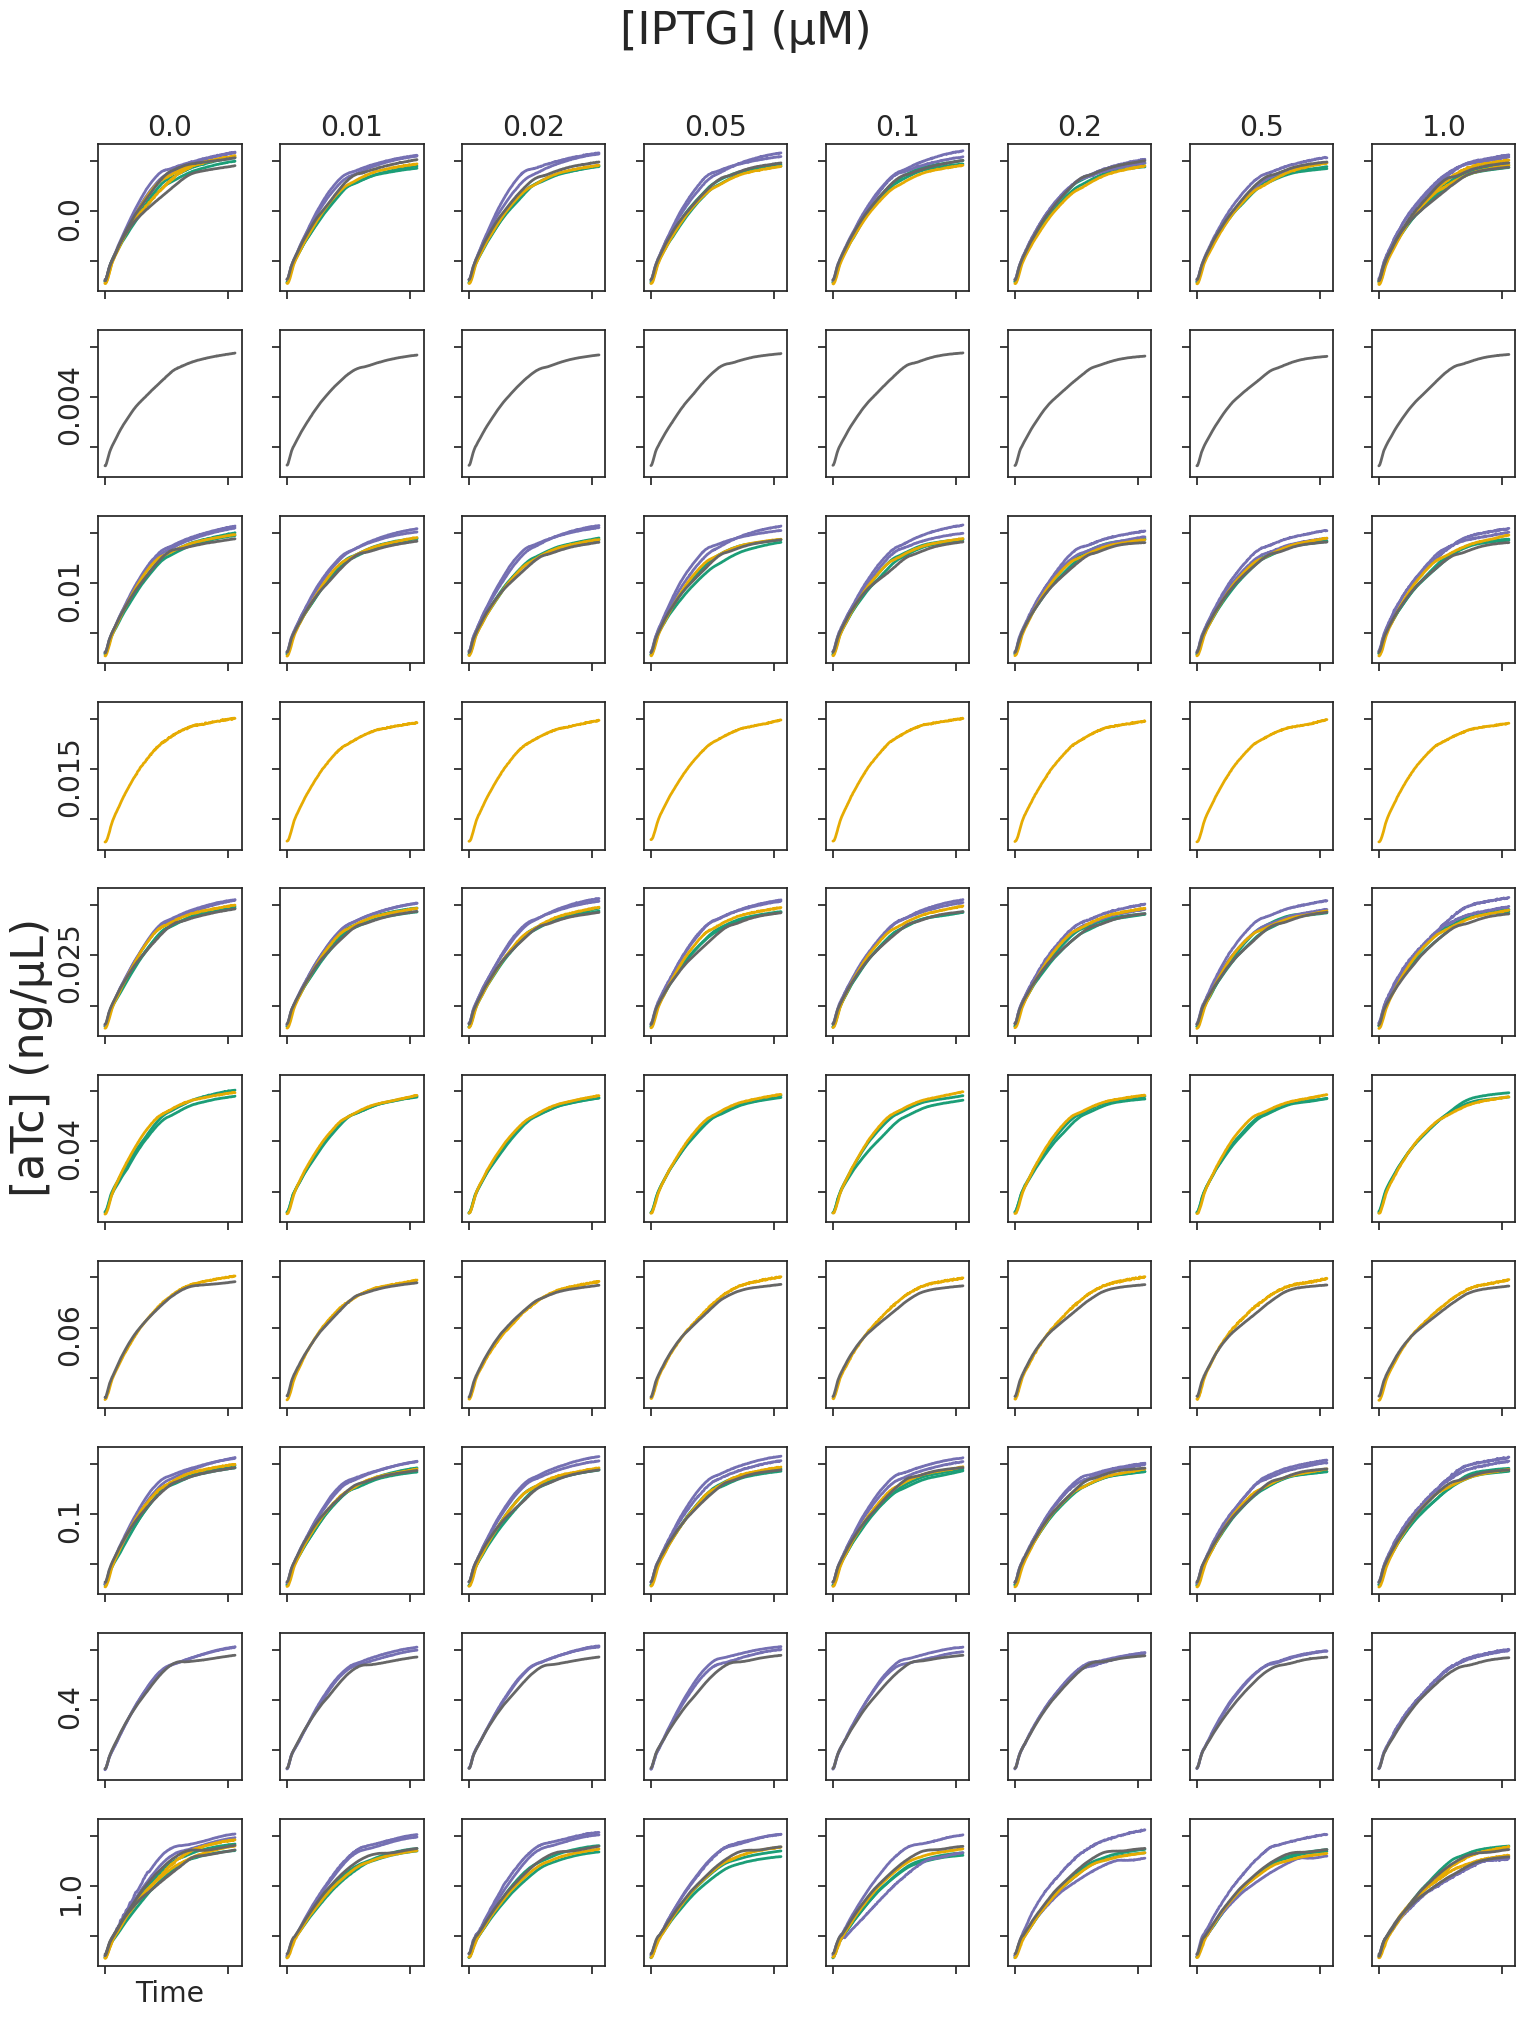

In [8]:
'''Plot OD time courses'''
plot_stacks(od_labeled,input_names)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f'{save_dir}{community}_OD_plots_v2.svg',format='svg')

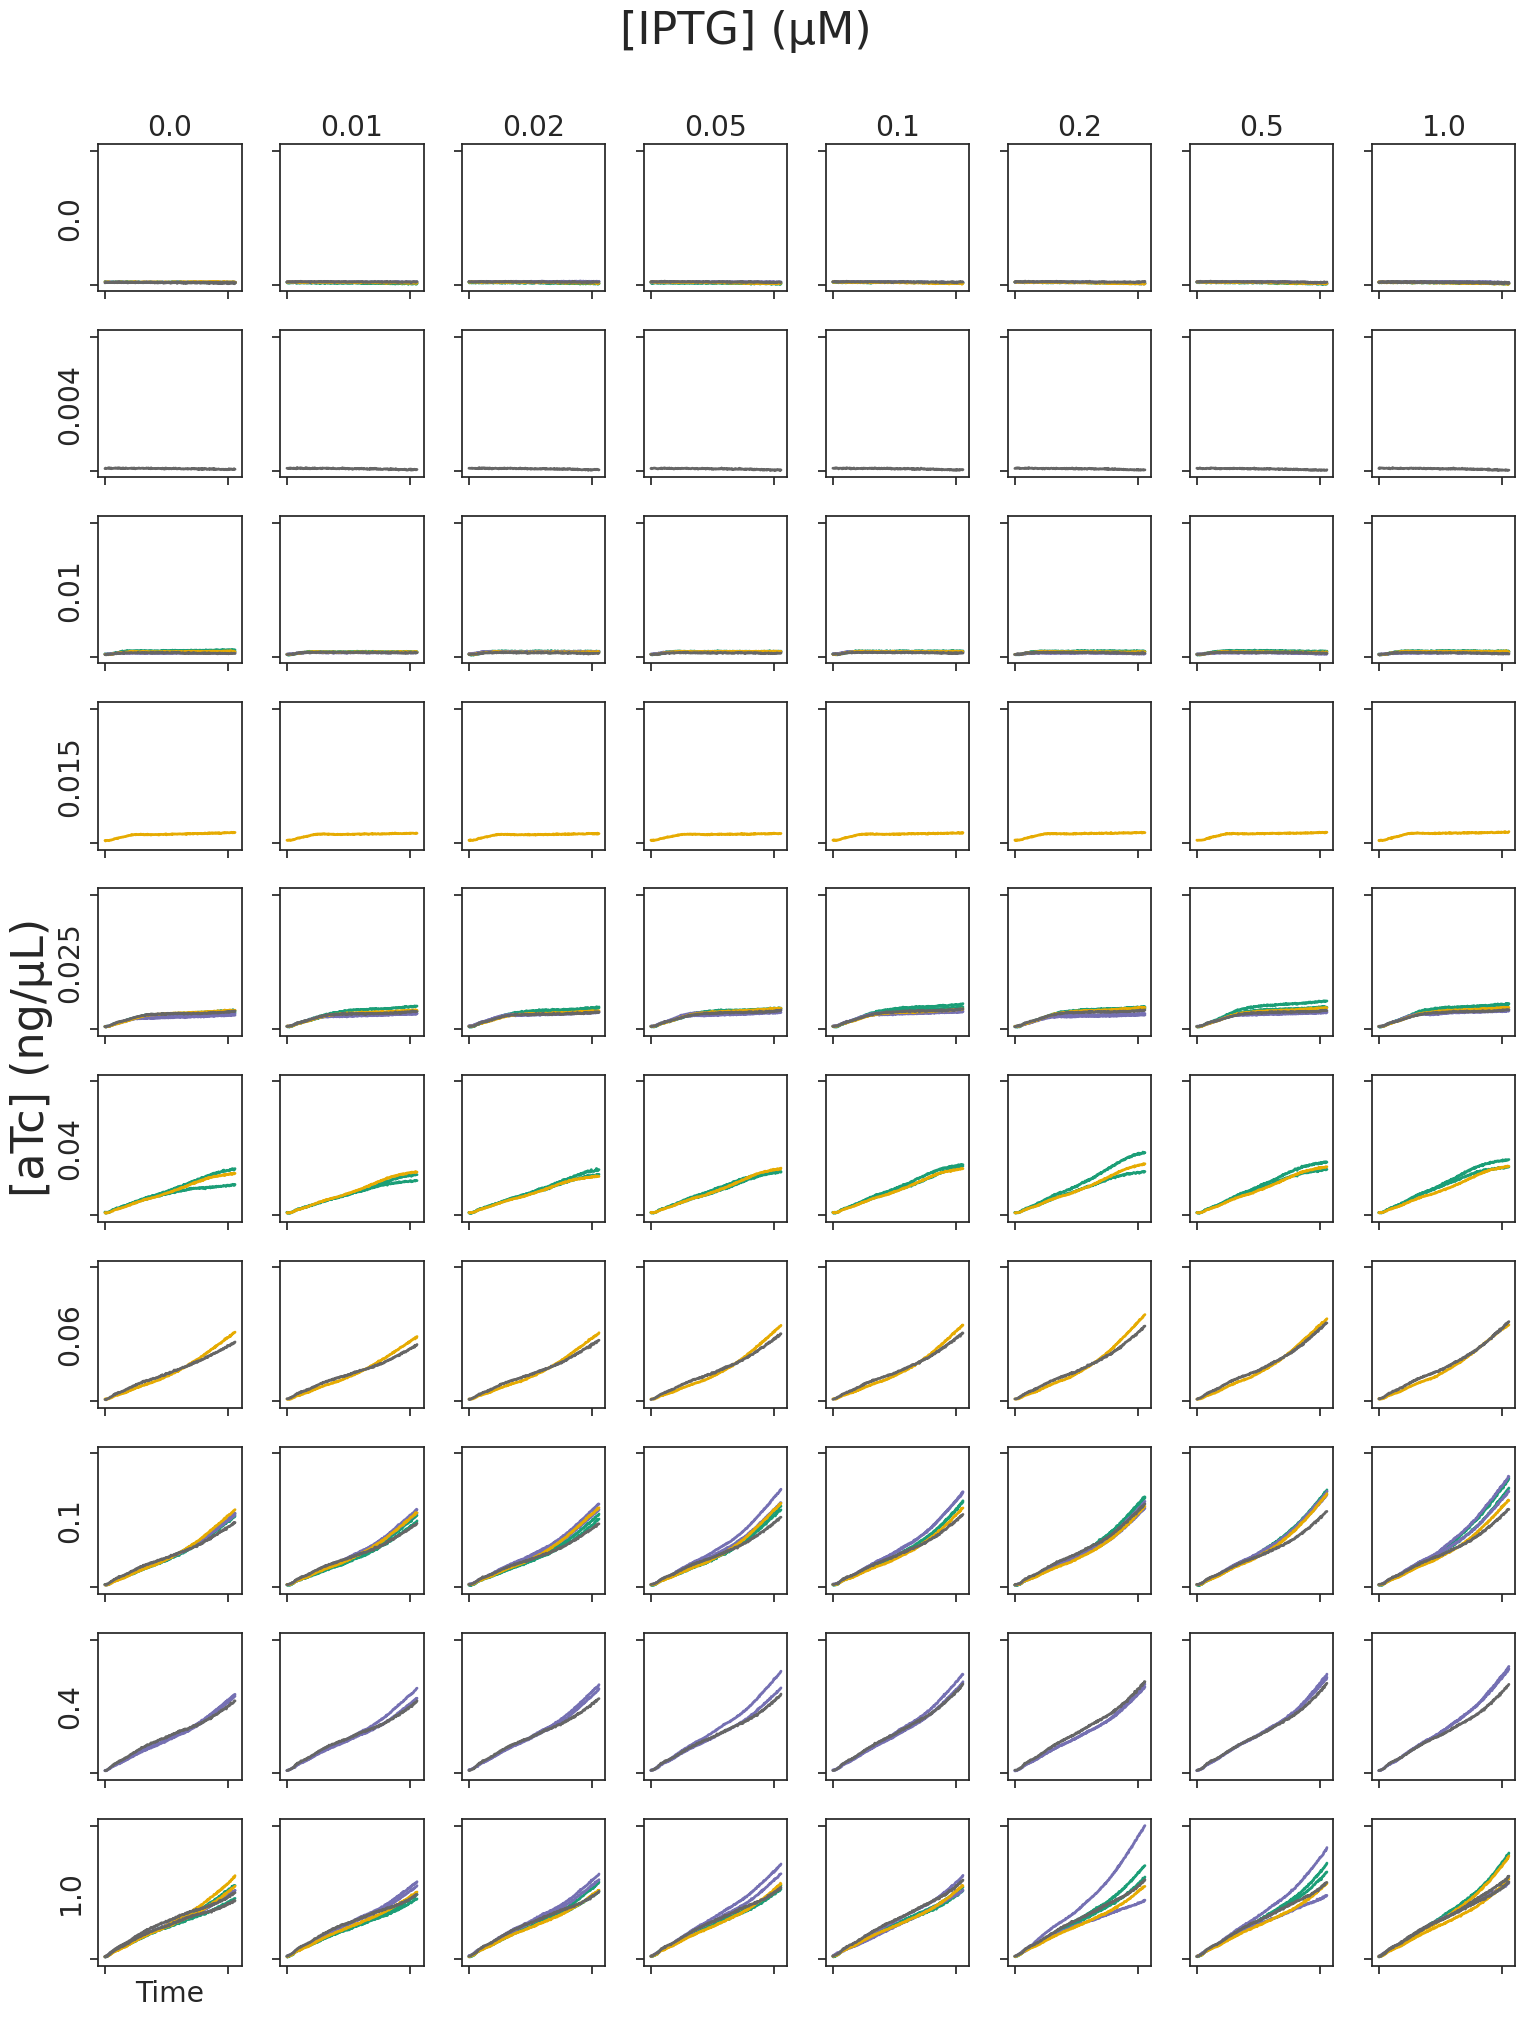

In [11]:
'''Plot fp1 time courses'''
plot_stacks(fp1_labeled,input_names)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f'{save_dir}{community}_{fluors[0]}_plots_v2.svg',format='svg')

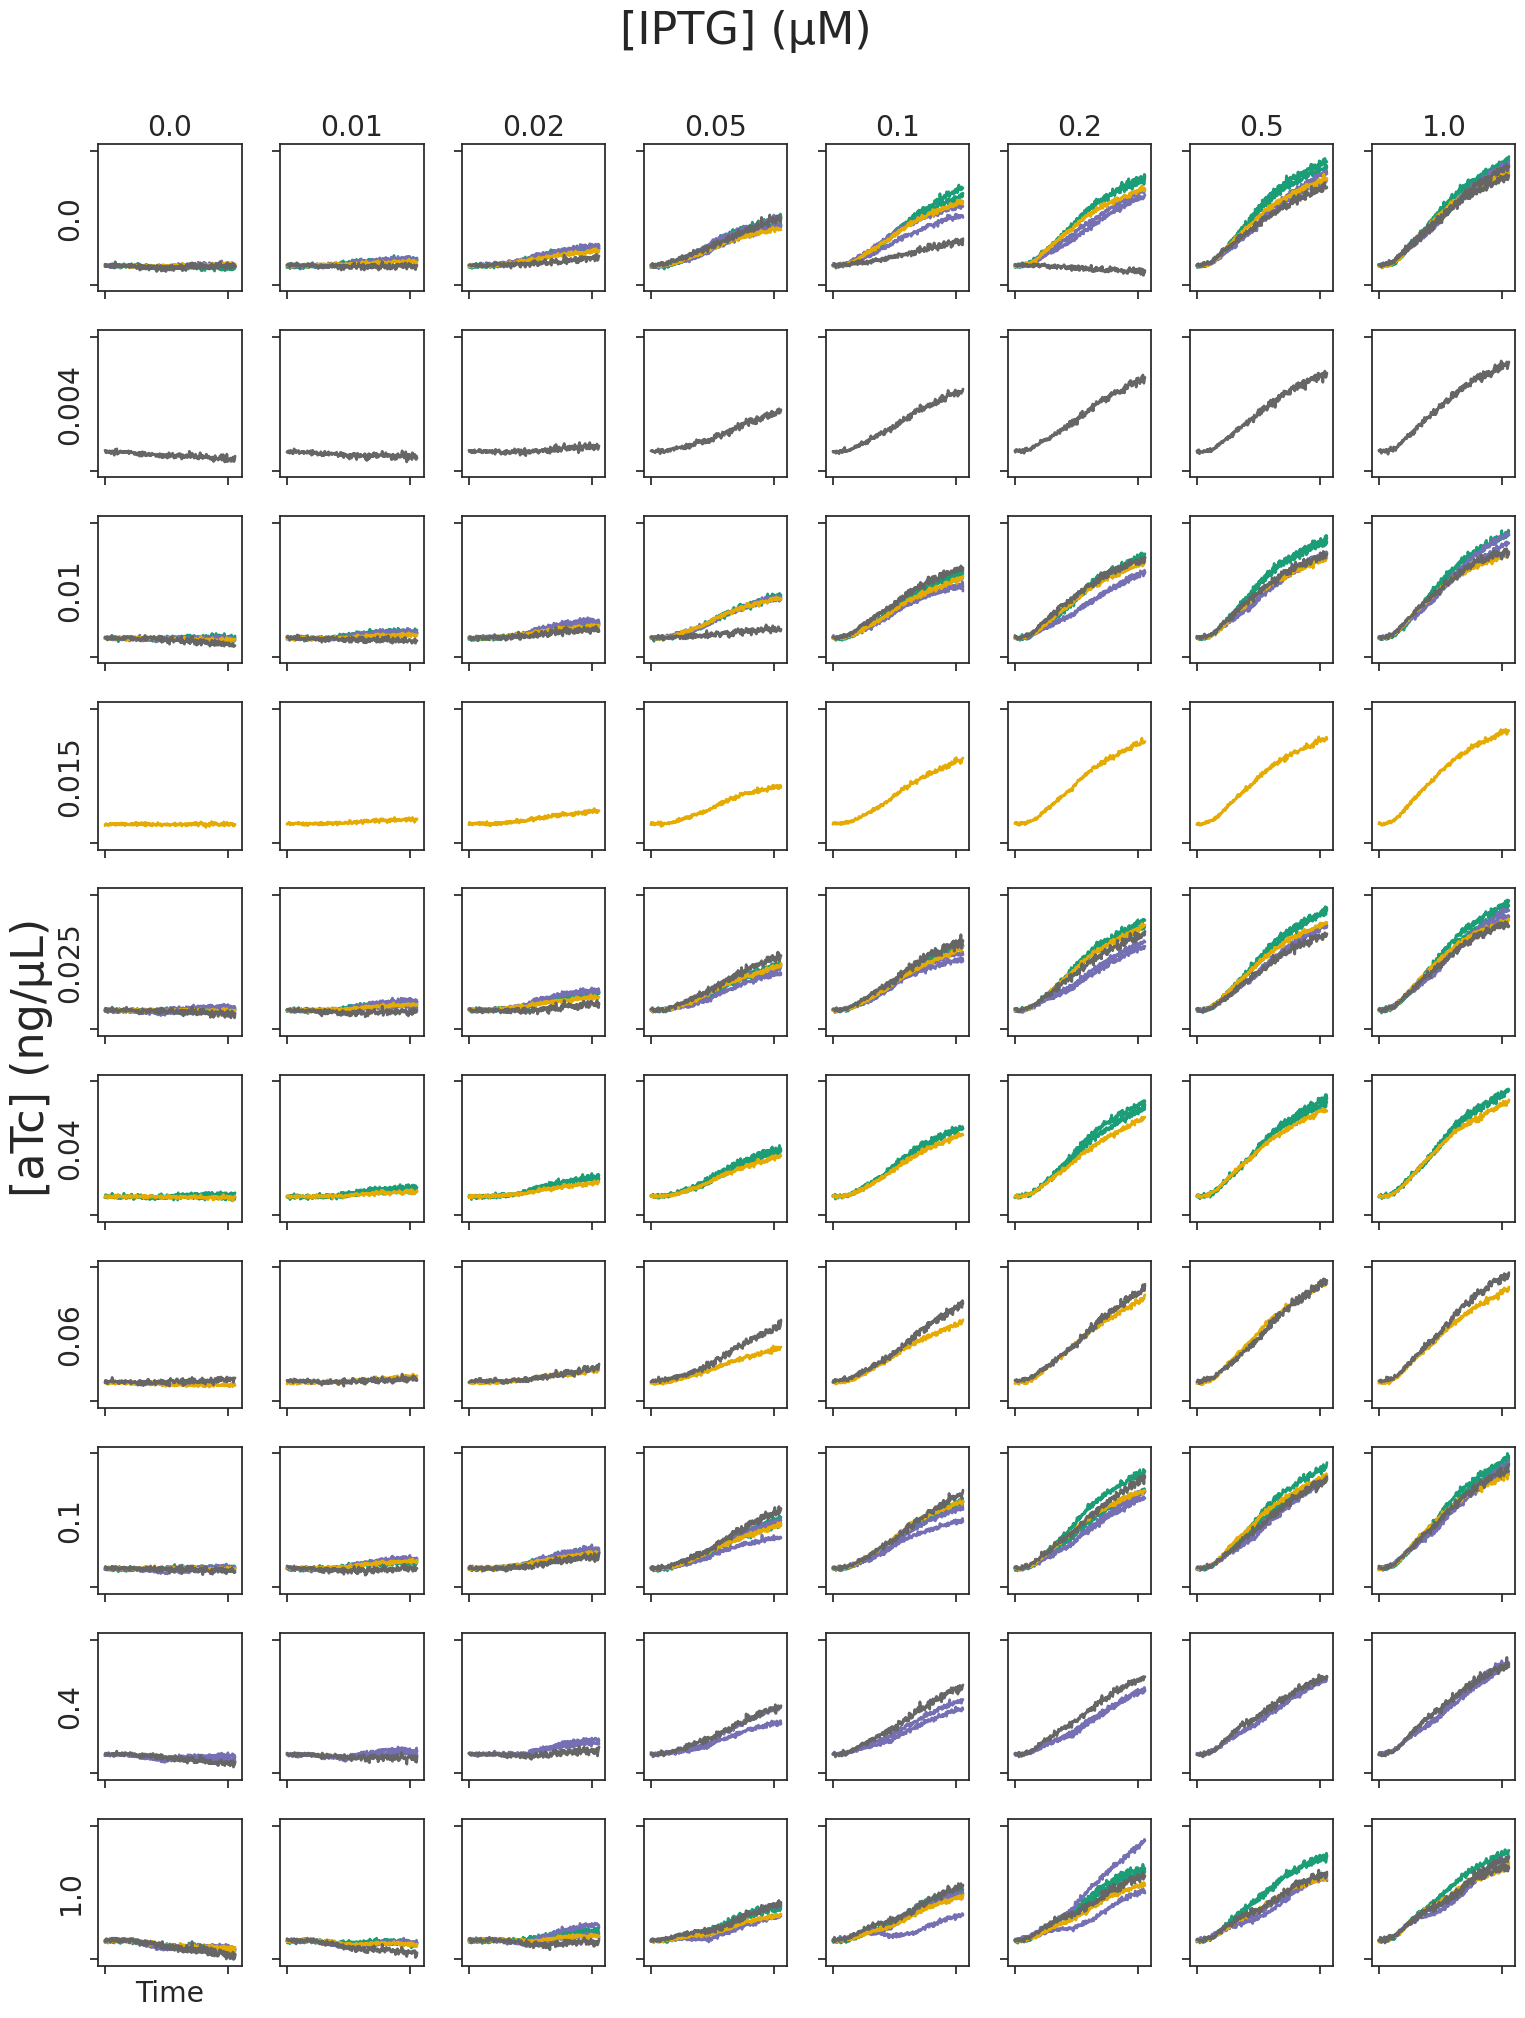

In [12]:
'''Plot fp2 time courses'''
plot_stacks(fp2_labeled,input_names)

#save figure
if community=='antibiotic_data':
    save_dir = f"figures/{community}/{plasmid}_{inhibitor}/"
else:
    save_dir = f"figures/{community}/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(f'{save_dir}{community}_{fluors[1]}_plots_v2.svg',format='svg')